# Faraday CAE

In this notebook we develop a Faraday convolutional autoencoder, and compare it to a Faraday autoencoder as well as a linear model.

## Data

We'll use the COSMOLOGY_1 POSSUM field.

In [1]:
import warnings

import astropy.io.fits, numpy, matplotlib.pyplot as plt, scipy.fftpack, astropy.units as units, astropy.wcs
import astropy.nddata
from astropy.coordinates import SkyCoord
import pandas
from tqdm import tqdm_notebook as tqdm

q_fits = astropy.io.fits.open('/run/user/697692/gvfs/sftp:host=miasma.anu.edu.au/home/alger/possum/alger/COSMOLOGY_1/image.restored.q.SB5136.contcube.3ax.fits')
u_fits = astropy.io.fits.open('/run/user/697692/gvfs/sftp:host=miasma.anu.edu.au/home/alger/possum/alger/COSMOLOGY_1/image.restored.u.SB5136.contcube.3ax.fits')

In [2]:
comps = pandas.read_csv('/run/user/697692/gvfs/sftp:host=miasma.anu.edu.au/home/alger/possum/alger/source-finding/COSMOLOGY_1_P_tbl_comp.csv')

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wcs = astropy.wcs.WCS(q_fits[0].header).dropaxis(3).dropaxis(2)

In [4]:
n_channels = q_fits[0].shape[0]
crval4 = q_fits[0].header['CRVAL4']
cdelt4 = q_fits[0].header['CDELT4']
freqs = numpy.arange(crval4, crval4 + cdelt4 * n_channels, cdelt4)[:n_channels] * units.Hz
wls = (astropy.constants.c / freqs).si ** 2

Let's grab some components. These images will have noise in them too, but less than a full image would.

In [5]:
comp_coords = SkyCoord(ra=comps._ra, dec=comps._dec, unit='deg')
test_idx = comps._peak_flux.idxmax()
test_component = comps.iloc[test_idx]
test_coord = comp_coords[test_idx]

In [28]:
# q = q_fits[0].data[:, 4000:4200, 3000:3200]
# u = u_fits[0].data[:, 4000:4200, 3000:3200]
qs = []
us = []
ps = []
wcss = []
for idx in tqdm(range(20)):
    coord = comp_coords[idx]
    q_ = astropy.nddata.Cutout2D(q_fits[0].data[0], coord, 2 * units.arcmin, wcs=wcs)
    bbox = (slice(0, n_channels),) + tuple([slice(*b) for b in q_.bbox_original])
    us.append(u_fits[0].data[bbox])
    qs.append(q_fits[0].data[bbox])
    ps.append(numpy.sqrt(us[-1] ** 2 + qs[-1] ** 2))
    wcss.append(q_.wcs)

In [29]:
skip_channels = [13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 27, 94, 97, 98, 99, 100, 101]

In [30]:
for q in tqdm(qs):
    q[skip_channels] = numpy.nan
for u in tqdm(us):
    u[skip_channels] = numpy.nan

Next we'll Fourier transform Q/U along $\lambda^2$. We will do this by assuming that our observations in $\lambda^2$ are samples.

In [57]:
percentile_90 = numpy.percentile(numpy.nanmean(ps, axis=1), 90, axis=(1, 2))
p_masks = numpy.nanmean(ps, axis=1) > percentile_90[:, None, None]
pixels = [q[:, m] + 1j * u[:, m] for q, u, m in zip(qs, us, p_masks)]
pixels = numpy.concatenate(pixels, axis=1)
pixels.shape

(102, 1680)

In [64]:
# Mainly based on RM-tools
n_samples = 10  # across RMSF
# Faraday depth range
d_freq = numpy.nanmin(numpy.abs(numpy.diff(freqs)))
wls_range = wls.max() - wls.min()
d_wls_min = numpy.min(numpy.abs(numpy.diff(wls)))
d_wls_max = numpy.max(numpy.abs(numpy.diff(wls)))
# Set the Faraday depth range
fwhm_rmsf = 2 * numpy.sqrt(3) / wls_range * units.rad
d_phi = fwhm_rmsf / n_samples
phi_max = max(600 / units.m ** 2, numpy.sqrt(3) / d_wls_max) * units.rad
# Faraday depth sampling. Zero always centred on middle channel
n_channels_rm = round(abs((phi_max - 0) / d_phi).value) * 2 + 1
start_phi = -(n_channels_rm - 1) * d_phi / 2
stop_phi =  +(n_channels_rm - 1) * d_phi / 2
# Make a phi sample array
phi_array = numpy.linspace(start_phi, stop_phi, n_channels_rm)
data_mask = numpy.isnan(pixels)
weights = data_mask != 1
p_cube = weights * pixels
# Initialise the complex Faraday Dispersion Function (FDF) cube
n_px = pixels.shape[1]
n_phi = phi_array.shape[0]
fdf_cube = numpy.zeros((n_px, n_phi), dtype=complex)
# Get the weighted mean of the LambdaSq distribution (B&dB Eqn. 32)
K = 1 / numpy.nansum(weights)
wls_0 = K * numpy.nansum(weights * wls[:, None])
a = (-2 * 1j * phi_array)
b = (wls - wls_0) 
arg = numpy.exp(numpy.outer(a, b))
n_pixels = n_px
for k in (range(n_px)):
    fdf_cube[k, :] = K * numpy.nansum(p_cube[:, k] * arg, axis=1)

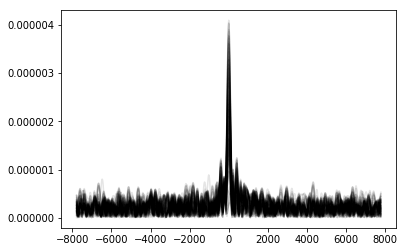

In [72]:
plt.plot(phi_array, abs(fdf_cube[:100]).T, c='k', alpha=0.1);

We now have some Faraday spectra. Let's build a simple autoencoder for this data.

In [76]:
import torch, torch.nn as nn
from torch.autograd import Variable

In [170]:
class Model(nn.Module):
    def __init__(self, n_inputs, n_hidden=10):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.encode_conv = nn.Sequential(
            nn.Conv1d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 32, 3, padding=1),
            nn.ReLU()
        )
        self.encode_linear = nn.Sequential(
            nn.Linear(n_inputs * 32, n_hidden),
            nn.ReLU(),
        )
        self.decode_linear = nn.Sequential(
            nn.Linear(n_hidden, n_inputs * 32),
            nn.ReLU(),
        )
        self.decode_conv = nn.Sequential(
            nn.ConvTranspose1d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 1, 3, padding=1),
            nn.ReLU(),  #  assumes non-negative output
        )

    def encode(self, x):
        x = self.encode_conv(x)
        x = x.view(-1, self.n_inputs * 32)
        return self.encode_linear(x)

    def decode(self, x):
        x = self.decode_linear(x).view(-1, 32, self.n_inputs)
        return self.decode_conv(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [157]:
model = Model(n_phi).double()

In [158]:
encoded = model.encode(torch.from_numpy(abs(fdf_cube[:15, None, :])))
decoded = model.decode(encoded)

In [165]:
torch_fdf_cube = torch.from_numpy(abs(fdf_cube[:, None, :]))
torch_fdf_cube = torch_fdf_cube / torch_fdf_cube.max()

In [166]:
model = Model(n_phi).double()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
n_epochs = 5
bar = tqdm(total=n_epochs)
for epoch in range(n_epochs):
    output = model(torch_fdf_cube)
    loss = criterion(output, torch_fdf_cube)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    bar.update(1)
    bar.postfix = ' {:.2e}'.format(loss.item())

In [169]:
torch_fdf_cube

tensor([[[0.0035, 0.0039, 0.0044,  ..., 0.0121, 0.0137, 0.0148]],

        [[0.0003, 0.0021, 0.0037,  ..., 0.0110, 0.0128, 0.0141]],

        [[0.0036, 0.0027, 0.0031,  ..., 0.0102, 0.0114, 0.0123]],

        ...,

        [[0.0024, 0.0031, 0.0037,  ..., 0.0030, 0.0041, 0.0055]],

        [[0.0036, 0.0033, 0.0030,  ..., 0.0032, 0.0036, 0.0045]],

        [[0.0034, 0.0039, 0.0044,  ..., 0.0032, 0.0040, 0.0050]]],
       dtype=torch.float64)